# Field Failure Data Analysis

## Import relevant module

In [1]:
# Uncomment lines below to install and enable progress bar in JupyterLab
# !pip install tqdm

# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [2]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt

# Reliability
from reliability.Fitters import Fit_Everything, Fit_Weibull_3P
from reliability.Reliability_testing import KStest
from reliability.Distributions import Weibull_Distribution
from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF

# Utilities
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdmn

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

## Utility functions

In [3]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file',filepath, 'this may take a while...\n')
        tuples = []

        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ
  
            tuples.append(tup)
        
        df_sens = pd.DataFrame(data = {'Window' : c_wins, 'Tuples' : tuples})
        df_sens.to_csv(filepath)

    else:
        print('File already exists!\n')
        df_sens = pd.read_csv(filepath, index_col = 0)
    
    return df_sens      

In [4]:
def tupling(dataframe, c_win, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file', filepath, 'this may take a while...\n')
        
        tup = 0
        prev = int(dataframe.loc[0,'Timestamp'])
        dataframe.loc[0,'Tuple'] = 0

        for index in range(dataframe.shape[0]-1):
            succ = int(dataframe.loc[index+1,'Timestamp'])
            if  succ - prev >= c_win:
                tup = tup + 1
            dataframe.loc[index+1,'Tuple'] = tup
            prev = succ
            
        dataframe.to_csv(filepath)

    else:
        print('File already exists!\n')
        dataframe = pd.read_csv(filepath, index_col = 0)
    
    return dataframe

In [5]:
def statistics(dataframe):
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']
    df_stat['Start time'] =  dataframe.groupby(by='Tuple').min(numeric_only = True)['Timestamp']
    df_stat['End time'] =  dataframe.groupby(by='Tuple').max(numeric_only = True)['Timestamp']
    df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
    df_temp = pd.DataFrame(data = {'Start time' : [np.nan]})
    df_temp = df_temp.append(df_stat, ignore_index = True)
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
        
    return df_stat

## Load Mercury data

In [6]:
df_mercury = pd.read_csv('Dataset/Mercury/MercuryErrorLog.txt', names = ['Timestamp', 'Node', 'Subsystem', 'Message'])

df_mercury.loc[:,'Node'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[1]
df_mercury.loc[:,'Subsystem'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[2]
df_mercury.loc[:,'Message'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[3]
df_mercury.loc[:,'Timestamp'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

print('Log file has ' + str(df_mercury.shape[0]) + ' entries and ' + str(df_mercury.shape[1]) + ' columns.')
df_mercury.head()

Log file has 80854 entries and 5 columns.


,Timestamp,Node,Subsystem,Message,Type
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,computation
1,1167637660,tg-c645,PRO,Device Error Info Section,computation
2,1167637660,tg-c645,PRO,Error Map: x,computation
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,computation
4,1167637720,tg-c645,PRO,Device Error Info Section,computation


# Data Manipulation

## System

### Temporal coalescence

#### Sensitivity analysis

File already exists!



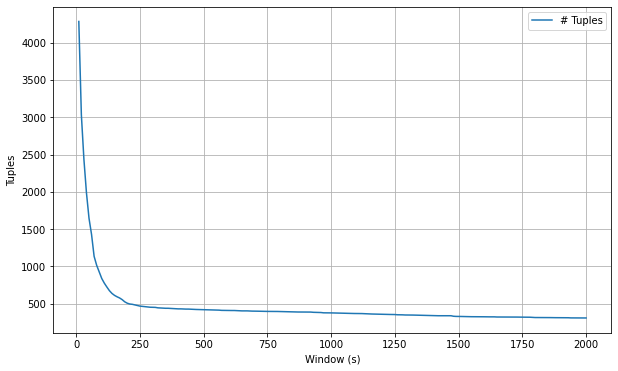

In [7]:
c_wins = np.delete(np.arange(0,2000,10), 0)

filepath = 'Dataset/Mercury/System/Mercury-Sensitivity.csv'

df_mercury_sensitivity = sensitivity_analysis(df_mercury, c_wins, filepath)

plt.figure(figsize=(10,6))
plt.plot(df_mercury_sensitivity['Window'],df_mercury_sensitivity['Tuples'], label = '# Tuples')
plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

#### Tupling

In [8]:
window = 250

filepath = 'Dataset/Mercury/System/Mercury-Data.csv'

df_mercury = tupling(df_mercury, window, filepath)
df_mercury = df_mercury.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_mercury.head()

File already exists!



,Timestamp,Node,Subsystem,Message,Tuple
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,0
1,1167637660,tg-c645,PRO,Device Error Info Section,0
2,1167637660,tg-c645,PRO,Error Map: x,0
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,0
4,1167637720,tg-c645,PRO,Device Error Info Section,0


In [9]:
num_tuple = df_mercury.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  469


In [10]:
df_sys_stat = statistics(df_mercury)
df_sys_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,6,1167637660,1167637720,60,0.100000,NaN
1,3,1167655228,1167655229,1,3.000000,17508.0
2,75,1167657137,1167657550,413,0.181598,1908.0
3,2,1167657941,1167657941,0,inf,391.0
4,27,1167658201,1167658456,255,0.105882,260.0


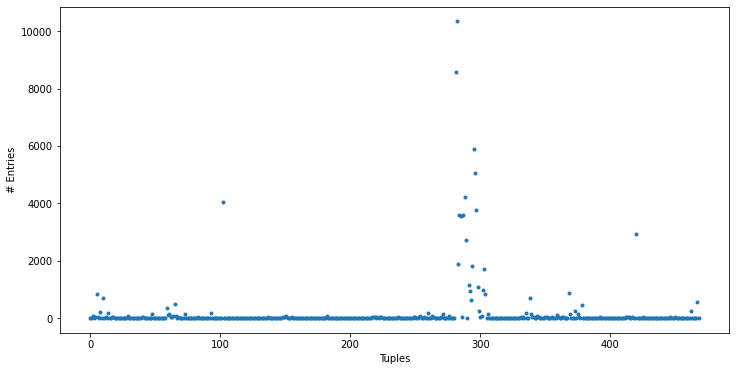

In [11]:
x = df_sys_stat.index
y = df_sys_stat['# Entries']

plt.figure(figsize=(12,6))
plt.scatter(x, y, marker = '.')
plt.xlabel('Tuples')
plt.ylabel('# Entries')
plt.show()

#### Bottleneck

In [12]:
start_tup = 281
end_tup = 306

df_bottleneck = df_mercury.loc[(df_mercury['Tuple']>=start_tup) & (df_mercury['Tuple']<=end_tup)]
df_bottleneck.head()

,Timestamp,Node,Subsystem,Message,Tuple
10162,1171321113,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,281
10163,1171321113,tg-c401,DEV,+Platform PCI Component Error Info Section,281
10164,1171321113,tg-c401,DEV,Component Info: Vendor Id =x x,281
10165,1171321156,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,281
10166,1171321156,tg-c401,DEV,+Platform PCI Component Error Info Section,281


In [13]:
df_bottleneck.groupby(by='Node').Timestamp.count().sort_values(ascending=False)

Node
tg-c401      62263
tg-login3      143
tg-login1      142
tg-s044        130
tg-master      102
tg-s176         13
tg-c027         12
tg-c106          7
tg-c781          6
tg-c407          4
tg-c735          3
tg-c669          3
tg-login2        2
tg-login4        2
tg-c128          2
tg-c894          1
tg-c685          1
Name: Timestamp, dtype: int64

In [14]:
df_bottleneck = df_bottleneck.loc[(df_bottleneck['Node']=='tg-c401')]
df_bottleneck.head()

,Timestamp,Node,Subsystem,Message,Tuple
10162,1171321113,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,281
10163,1171321113,tg-c401,DEV,+Platform PCI Component Error Info Section,281
10164,1171321113,tg-c401,DEV,Component Info: Vendor Id =x x,281
10165,1171321156,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,281
10166,1171321156,tg-c401,DEV,+Platform PCI Component Error Info Section,281


### Spatial coalescence

In [15]:
df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

In [16]:
print('Number of nodes that generates error: ' + str(len(df_mercury['Node'].unique())))

Number of nodes that generates error: 53


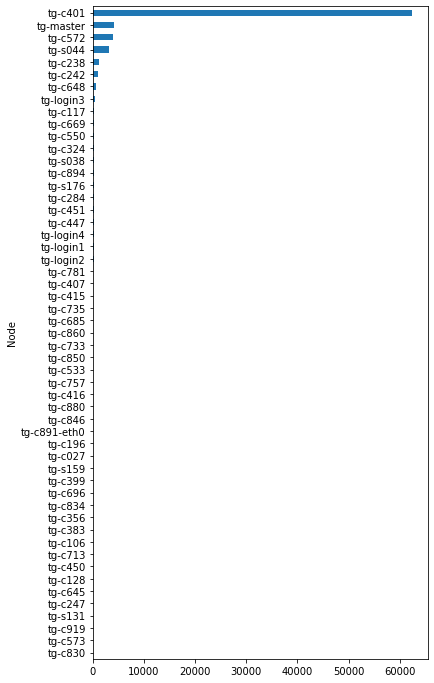

In [17]:
plt.figure(figsize=(6,12))
df_mercury.groupby(by='Node').Timestamp.count().sort_values().plot.barh()
plt.show()

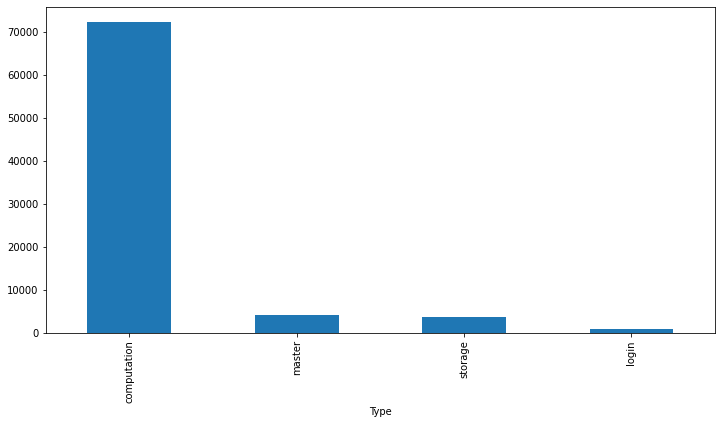

In [18]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

### Content-based coalescence

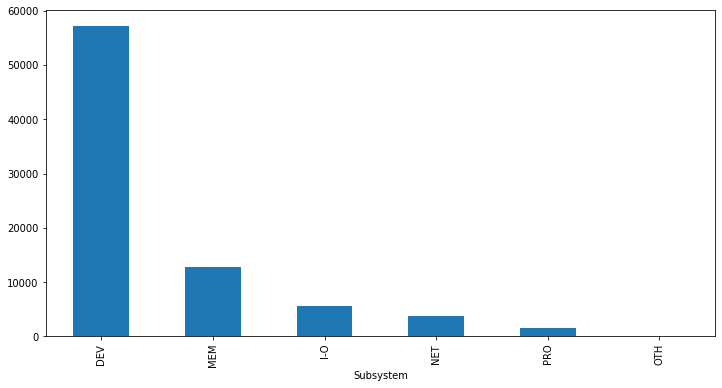

In [19]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

In [20]:
# Fare altre osservazioni
df_mercury.groupby(by=['Subsystem','Type']).count()

Timestamp   Node  Message  Tuple
Subsystem Type                                         
DEV       computation      57037  57037    57037  57037
          master               3      3        3      3
          storage            208    208      208    208
I-O       computation        802    802      802    802
          login              820    820      820    820
          master             452    452      452    452
          storage           3473   3473     3473   3473
MEM       computation      12818  12818    12818  12818
          master               1      1        1      1
NET       computation         56     56       56     56
          login                3      3        3      3
          master            3639   3639     3639   3639
          storage              4      4        4      4
OTH       computation         17     17       17     17
          master               3      3        3      3
          storage             14     14       14     14
PRO       computation       1504   1504     1504   1504

<AxesSubplot:ylabel='Subsystem'>

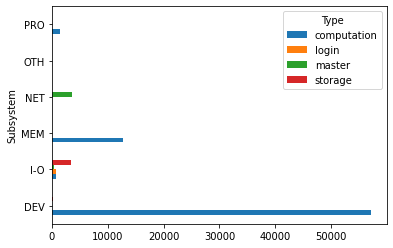

In [21]:
df_mercury.groupby(by=['Subsystem','Type']).Timestamp.count().unstack(1).plot.barh()

### Truncation analysis

In [22]:
q = df_sys_stat['Interarrival'].quantile(q=0.1)
print("0.1 quantile: " + str(q))

0.1 quantile: 491.90000000000003


In [23]:
df_trunc = df_sys_stat.loc[df_sys_stat['Interarrival'] <= q]
df_trunc.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
3,2,1167657941,1167657941,0,inf,391.0
4,27,1167658201,1167658456,255,0.105882,260.0
5,825,1167658913,1167665307,6394,0.129027,457.0
6,22,1167665787,1167665982,195,0.112821,480.0
9,17,1167669001,1167669463,462,0.036797,377.0


In [24]:
num_trunc = df_trunc.shape[0]
perc_trunc = (num_trunc/num_tuple)*100

print('Estimate number of truncations:', num_trunc)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 47
Estimate percentage of truncations: 10.021321961620469


In [25]:
df_group = df_mercury.groupby(by=['Tuple','Node']).count()
df_group.tail()

Timestamp  Subsystem  Message  Type
Tuple Node                                          
466   tg-master          4          4        4     4
467   tg-c128            2          2        2     2
      tg-c196            2          2        2     2
      tg-master        558        558      558   558
468   tg-c196            2          2        2     2

In [26]:
df_group = df_group.reset_index(level = 1)

truncated = 0
for tup in df_trunc.index:

    df_tup = df_group.loc[df_group.index == tup]    
    node = df_tup.loc[df_tup['Timestamp'] == df_tup.max()['Timestamp'], 'Node'].item()
    
    df_tup_prec = df_group.loc[df_group.index == tup-1]
    node_prec = df_tup_prec.loc[df_tup_prec['Timestamp'] == df_tup_prec.max()['Timestamp'], 'Node'].item()
    
    if node == node_prec:
        truncated = truncated +1

In [27]:
perc_trunc = (truncated/num_tuple)*100

print('Estimate number of truncations:', truncated)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 38
Estimate percentage of truncations: 8.102345415778252


### Collision analysis

In [28]:
collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [29]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 51
Estimate percentage of collisions:  10.874200426439232


## Subsystems

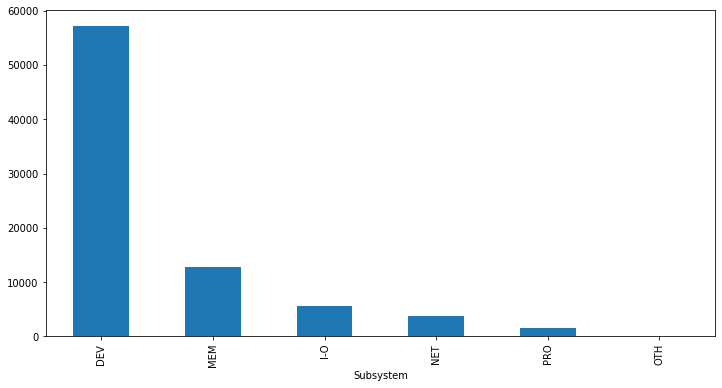

In [30]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

In [31]:
subsystems = df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).drop('OTH')

### Temporal coalescence

#### Sensitivity analysis

In [32]:
c_wins = np.delete(np.arange(0,500,1), 0)

for subsys in subsystems.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Subsystems/Mercury-' + subsys + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



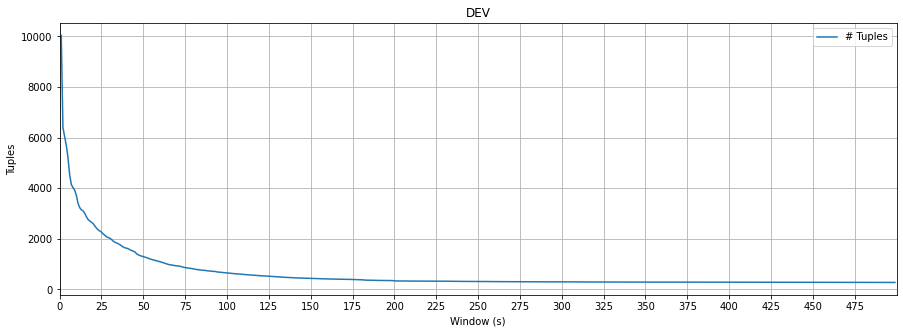

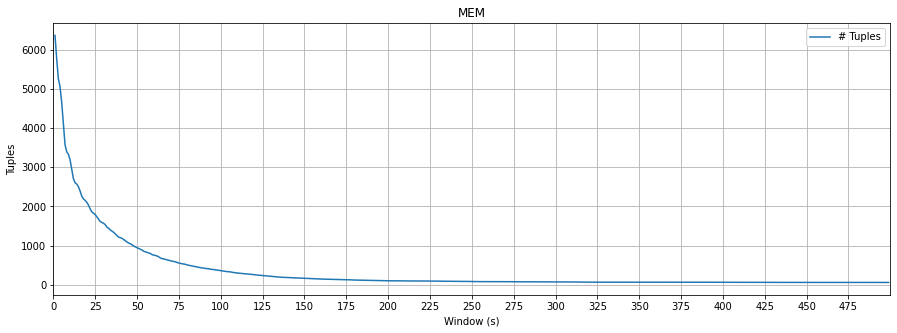

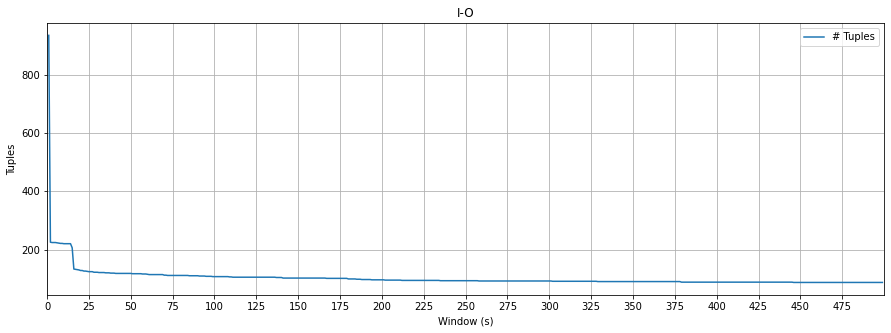

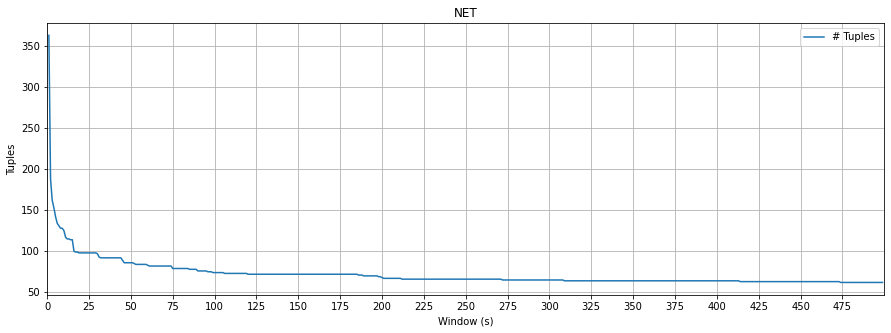

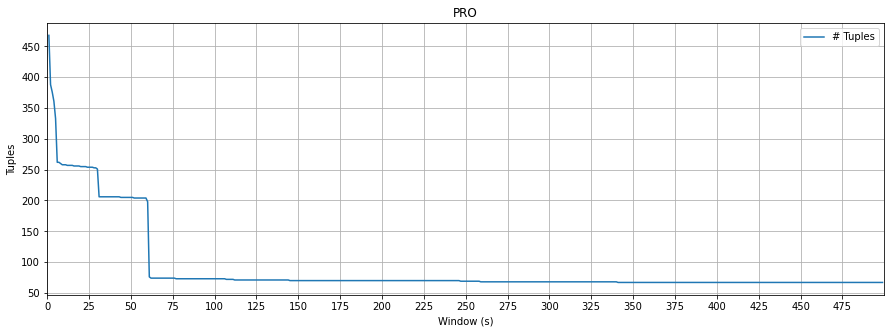

In [33]:
for subsys in subsystems.index:
    filepath = 'Dataset/Mercury/Subsystems/Mercury-' + subsys + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(15,5))
    plt.plot(x, y, label = '# Tuples')
    plt.title(subsys)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()

In [34]:
win_dict = {'DEV' : 200,
            'MEM' : 200,
            'I-O' : 100,
            'NET' : 100,
            'PRO' : 100}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'DEV': 200, 'MEM': 200, 'I-O': 100, 'NET': 100, 'PRO': 100}


#### Tupling

In [35]:
dict_df_cat_stat = {}
dict_cat_num_tup = {}

for subsys in subsystems.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Subsystems/Mercury-' + subsys + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[subsys], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_cat_num_tup[subsys] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_cat_stat[subsys] = df_stat

print('Number of tuples:', dict_cat_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'DEV': 334, 'MEM': 105, 'I-O': 107, 'NET': 74, 'PRO': 73}


## Types

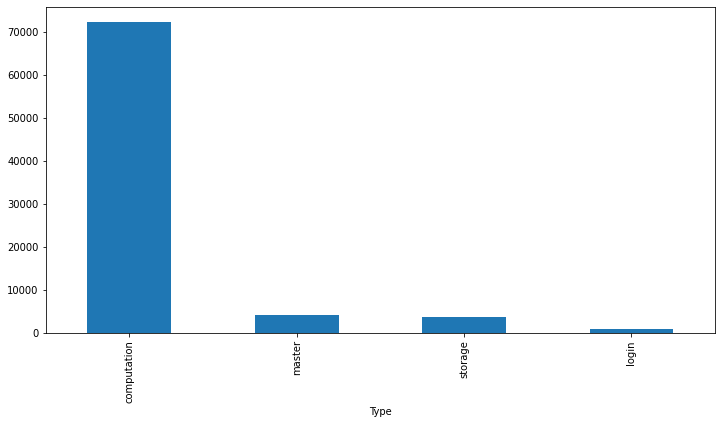

In [36]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

In [37]:
types = df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False)

### Temporal coalescence

#### Sensitivity analysis

In [38]:
c_wins = np.delete(np.arange(0,500,1), 0)

for t in types.index:
    df_temp = df_mercury.loc[df_mercury['Type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Types/Mercury-' + t + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!



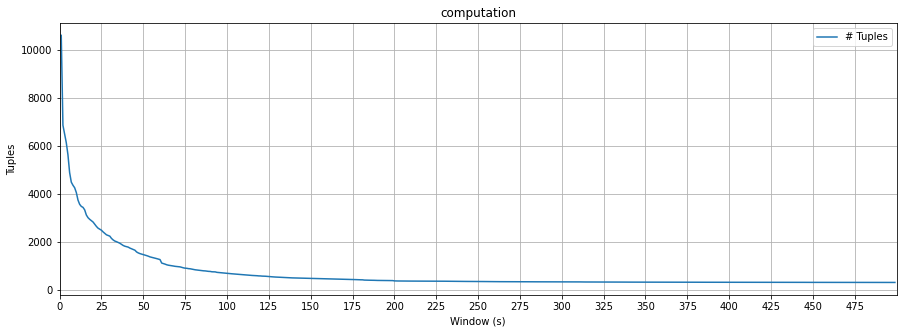

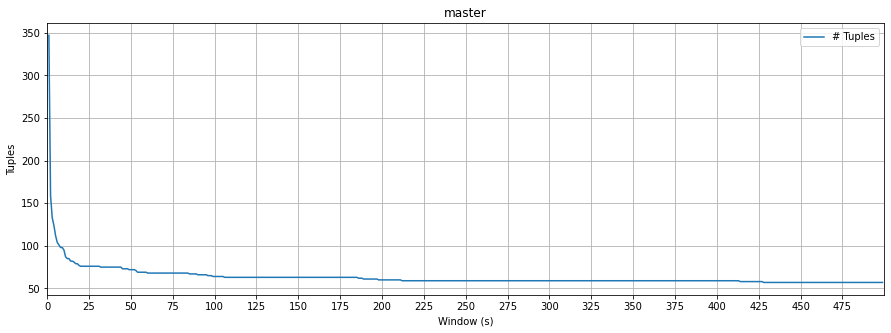

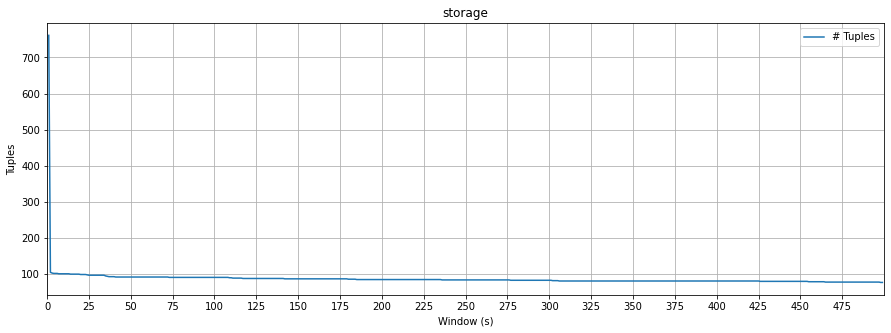

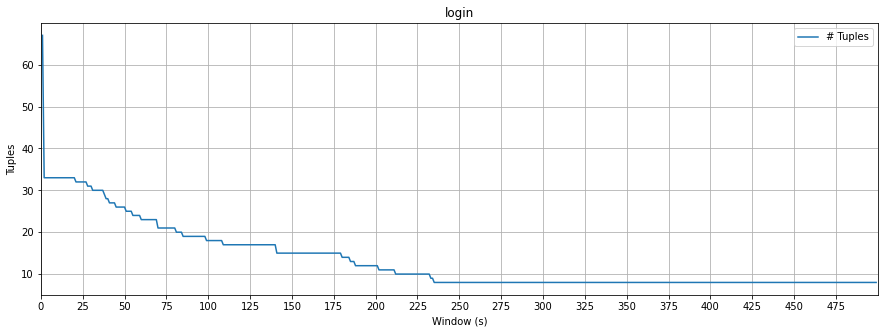

In [39]:
for t in types.index:
    filepath = 'Dataset/Mercury/Types/Mercury-' + t + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(15,5))
    plt.plot(x, y, label = '# Tuples')
    plt.title(t)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()

In [40]:
win_dict = {'computation' : 200,
            'master' : 150,
            'storage' : 100,
            'login' : 300}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'computation': 200, 'master': 150, 'storage': 100, 'login': 300}


#### Tupling

In [41]:
dict_df_type_stat = {}
dict_type_num_tup = {}

for t in types.index:
    df_temp = df_mercury.loc[df_mercury['Type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Types/Mercury-' + t + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[t], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_type_num_tup[t] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_type_stat[t] = df_stat

print('Number of tuples:', dict_type_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'computation': 382, 'master': 63, 'storage': 91, 'login': 8}


## Top nodes

In [42]:
print('Number of nodes that generates error: ' + str(len(df_mercury['Node'].unique())))

Number of nodes that generates error: 53


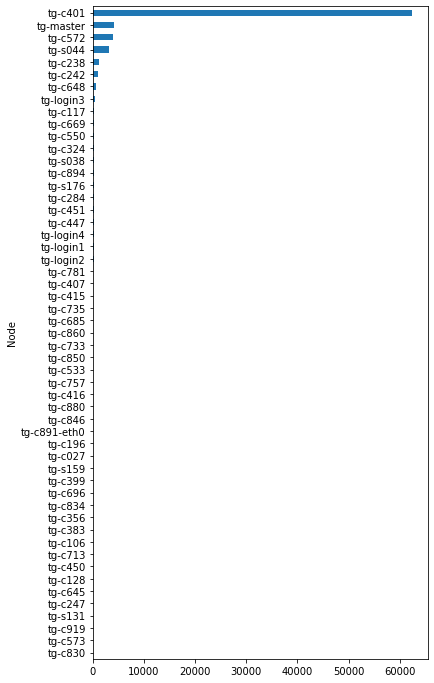

In [43]:
plt.figure(figsize=(6,12))
df_mercury.groupby(by='Node').Timestamp.count().sort_values().plot.barh()
plt.show()

In [44]:
top_5 = df_mercury.groupby(by='Node').Timestamp.count().sort_values(ascending = False)[0:5]
top_5

Node
tg-c401      62340
tg-master     4098
tg-c572       4030
tg-s044       3224
tg-c238       1273
Name: Timestamp, dtype: int64

### Temporal coalescence

#### Sensitivity analysis

In [45]:
c_wins = np.delete(np.arange(0,500,1), 0)

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/TopNodes/Mercury-' + node + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



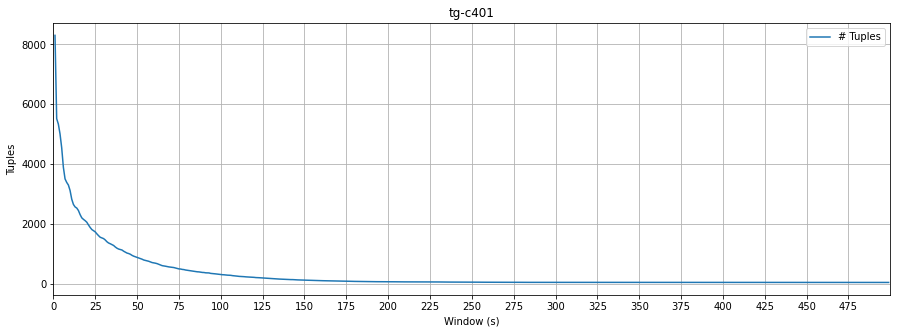

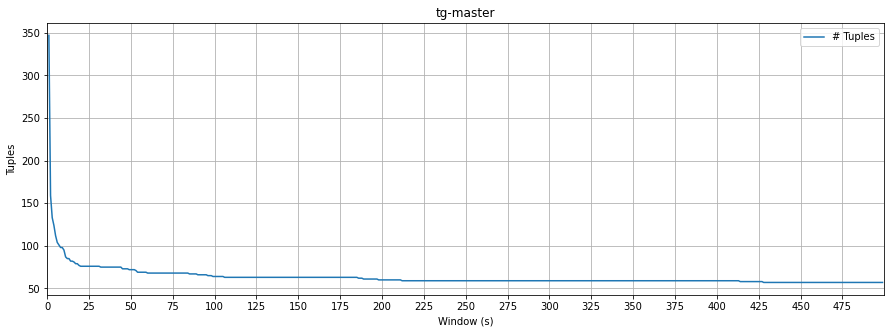

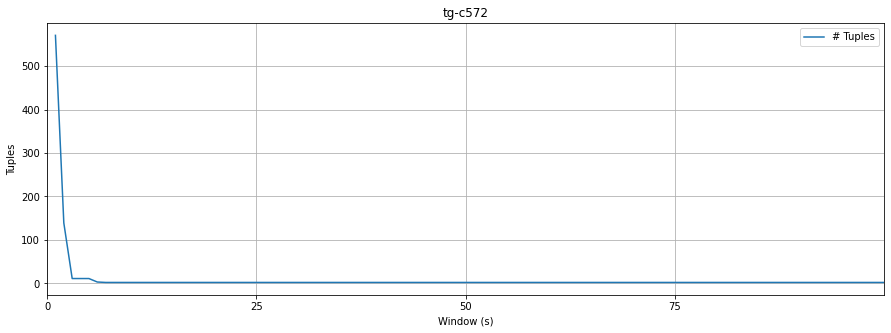

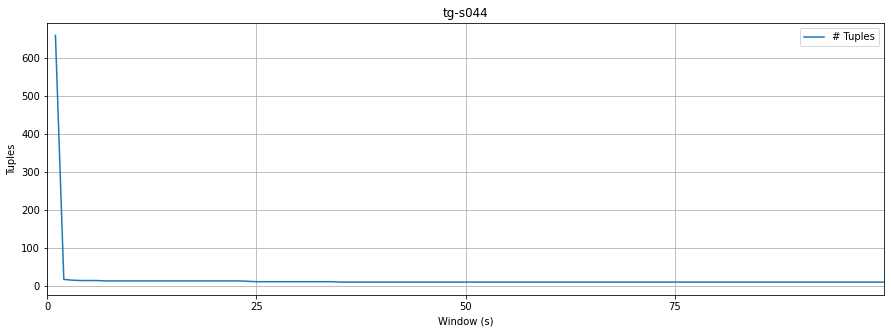

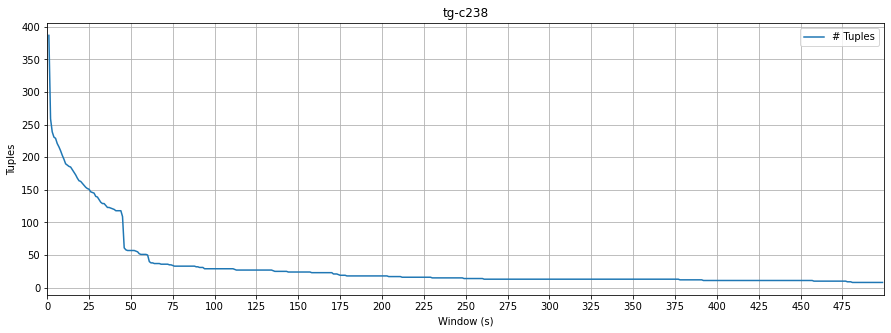

In [46]:
x_dict = {'tg-c401' : 500,
          'tg-master' : 500,
          'tg-c572' : 100,
          'tg-s044' : 100,
          'tg-c238' : 500}

for node in top_5.index:
    filepath = 'Dataset/Mercury/TopNodes/Mercury-' + node + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(15,5))
    plt.plot(x, y, label = '# Tuples')
    plt.title(node)
    plt.xlim(0,x_dict[node])
    plt.xticks(np.arange(0, x_dict[node], step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()

In [47]:
win_dict = {'tg-c401' : 200,
            'tg-master' : 200,
            'tg-c572' : 20,
            'tg-s044' : 30,
            'tg-c238' : 200}

print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'tg-c401': 200, 'tg-master': 200, 'tg-c572': 20, 'tg-s044': 30, 'tg-c238': 200}


#### Tupling

In [48]:
dict_df_node_stat = {}
dict_node_num_tup = {}

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/TopNodes/Mercury-' + node + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[node], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_node_num_tup[node] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_node_stat[node] = df_stat
    
print('Number of tuples:', dict_node_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'tg-c401': 59, 'tg-master': 60, 'tg-c572': 2, 'tg-s044': 11, 'tg-c238': 18}


## Bottleneck

### Temporal coalescence

#### Sensitivity analysis

File already exists!



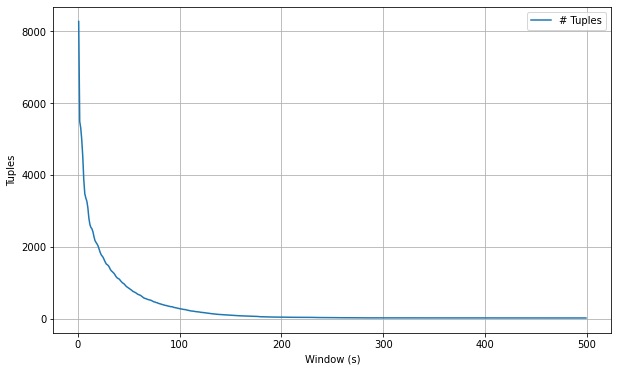

In [49]:
c_wins = np.delete(np.arange(0,500,1), 0)

filepath = 'Dataset/Mercury/Bottleneck/Mercury-bottleneck-Sensitivity.csv'

df_bottleneck.reset_index(drop = True, inplace = True)
df_bottleneck_sensitivity = sensitivity_analysis(df_bottleneck, c_wins, filepath)

plt.figure(figsize=(10,6))

plt.plot(df_bottleneck_sensitivity['Window'], df_bottleneck_sensitivity['Tuples'], label = '# Tuples')

plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

#### Tupling

In [50]:
window = 200
filepath = 'Dataset/Mercury/Bottleneck/Mercury-bottleneck-Data.csv'

df_bottleneck = tupling(df_bottleneck, window, filepath)
df_bottleneck = df_bottleneck.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bottleneck.head()

File already exists!



,Timestamp,Node,Subsystem,Message,Tuple,Type
0,1171321113,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,0,computation
1,1171321113,tg-c401,DEV,+Platform PCI Component Error Info Section,0,computation
2,1171321113,tg-c401,DEV,Component Info: Vendor Id =x x,0,computation
3,1171321156,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,0,computation
4,1171321156,tg-c401,DEV,+Platform PCI Component Error Info Section,0,computation


In [51]:
num_tuple = df_bottleneck.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  37


In [52]:
df_bottleneck_stat = statistics(df_bottleneck)
df_bottleneck_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,8569,1171321113,1171337216,16103,0.532137,NaN
1,9822,1171337536,1171356961,19425,0.505637,320.0
2,503,1171357195,1171358506,1311,0.383677,234.0
3,11,1171358737,1171358737,0,inf,231.0
4,1133,1171359013,1171360978,1965,0.576590,276.0


# Data analysis

## System

### Empirical time to failure distribution

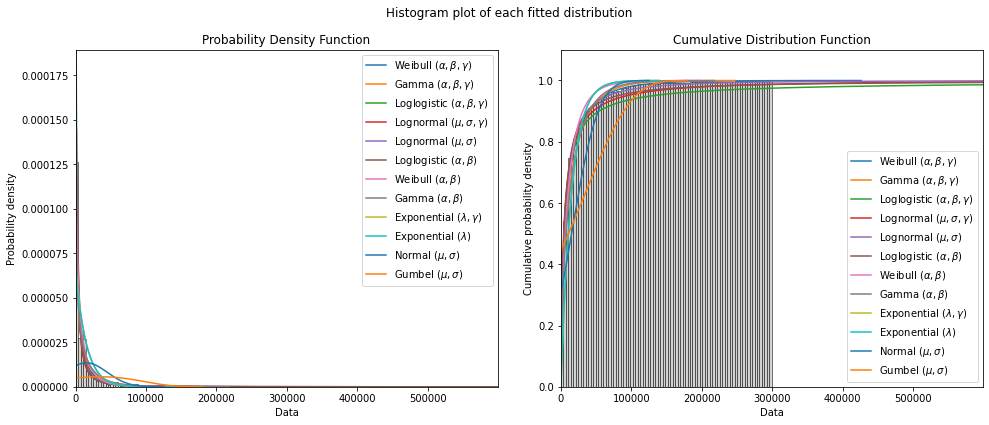

The best fitting distribution was Weibull_3P which had parameters [9.30684336e+03 5.80580908e-01 2.52999900e+02]


In [53]:
data = df_sys_stat['Interarrival'].dropna().to_numpy()

results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

In [54]:
results.results

,Alpha,Beta,Gamma,Mu,Sigma,Lambda,AICc,BIC,AD
Distribution,,,,,,,,,
Weibull_3P,9306.84,0.580581,253,,,,9621.937663,9634.331344,0.781407
Gamma_3P,33518.5,0.446207,253,,,,9648.930935,9661.324616,3.413044
Loglogistic_3P,4136.65,0.854912,253,,,,9664.960542,9677.354223,2.939155
Lognormal_3P,,,235.79,8.23439,1.94723,,9665.315113,9677.708794,3.121882
Lognormal_2P,,,,8.46357,1.61232,,9701.159540,9709.430670,2.680266
Loglogistic_2P,4738.95,1.04178,,,,,9732.209731,9740.480861,3.557992
Weibull_2P,10213.1,0.748365,,,,,9776.423817,9784.694947,6.794443
Gamma_2P,28241.9,0.538533,,,,,9797.951246,9806.222376,9.079964
Exponential_2P,,,252.999,,,6.68621e-05,9937.680059,9945.951189,78.956474


Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error     Lower CI      Upper CI
Parameter                                                           
Alpha         9306.843358      781.146430  7895.123887  10970.991022
Beta             0.580581        0.020628     0.541527      0.622452
Gamma          252.999900        0.000154   252.999598    253.000202
Log-Likelihood: -4807.94296952023 



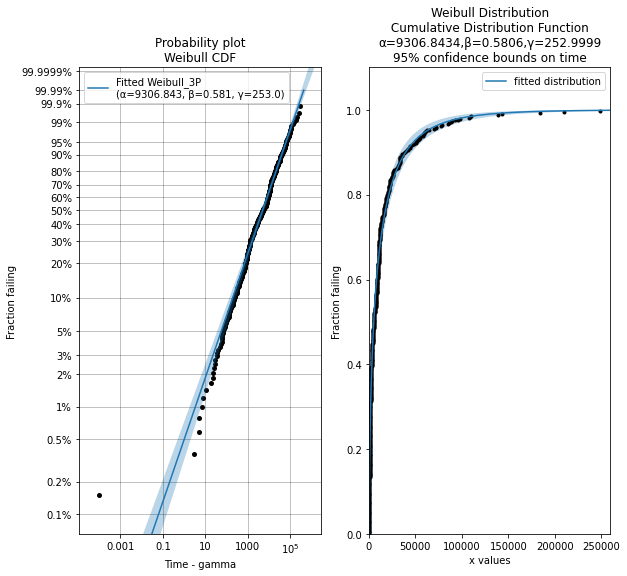

In [55]:
alpha = results.results.loc['Weibull_3P','Alpha']
beta = results.results.loc['Weibull_3P','Beta']
gamma = results.results.loc['Weibull_3P','Gamma']

plt.subplot(121)
fit = Fit_Weibull_3P(failures=data)
plt.subplot(122)
fit.distribution.CDF(label='fitted distribution')
plot_points(failures=data, func='CDF')

plt.legend()
plt.show()

Kolmogorov-Smirnov statistic: 0.03571182296387798
Kolmogorov-Smirnov critical value: 0.062344368163325344
At the 0.05 significance level, we can ACCEPT the hypothesis that the data comes from a Weibull Distribution (α=9306.8434,β=0.5806,γ=252.9999)


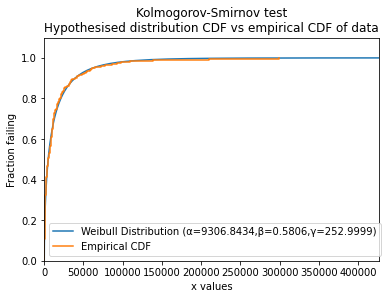

In [56]:
dist = Weibull_Distribution(alpha=alpha, beta=beta, gamma=gamma)

result = KStest(distribution = dist, data = df_sys_stat['Interarrival'].to_numpy(), significance = 0.05)

### Empirical reliability

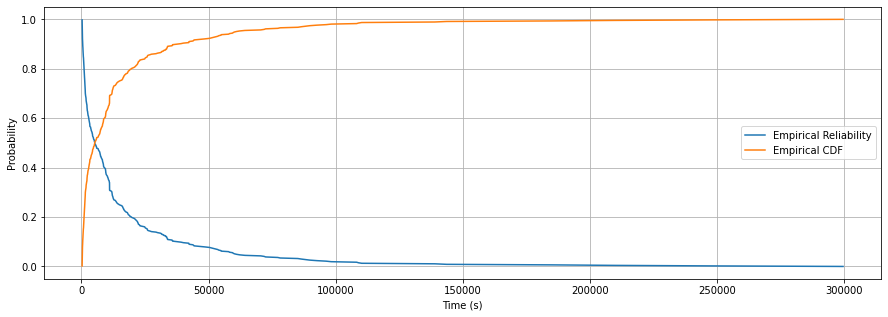

In [57]:
ecdf = ECDF(data)

plt.figure(figsize=(15,5))
    
plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()

### General Analysis

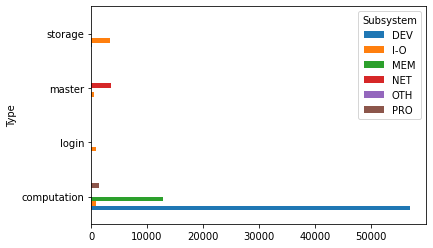

In [58]:
df_mercury.groupby(by=['Subsystem','Type']).Timestamp.count().unstack(0).plot.barh()
plt.show()

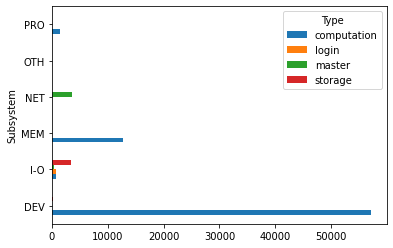

In [59]:
df_mercury.groupby(by=['Subsystem','Type']).Timestamp.count().unstack(1).plot.barh()
plt.show()

In [60]:
print('Distinct error messages:', df_mercury.groupby(by='Message').count().shape[0])

Distinct error messages: 48


In [61]:
df_mercury.groupby(by='Message').count().sort_values(by='Timestamp', ascending=False).head(10).drop(columns=df_mercury.groupby(by='Message').count().columns[1:5])

,Timestamp
Message,
Component Info: Vendor Id =x x,25712
Physical Address x,12746
+Platform PCI Component Error Info Section,8221
+BEGIN HARDWARE ERROR STATE AT CPE,7498
+ Platform Specific Error Detail:,5929
+Platform Specific Error Info Section,5812
+END HARDWARE ERROR STATE AT CPE,4021
setting node state to down,3635
error: dev x:x,2944


In [62]:
df_mercury.groupby(by=['Subsystem','Message']).count().drop(columns=['Node', 'Type', 'Tuple'])

Timestamp
Subsystem Message                                                      
DEV       + Platform Specific Error Detail:                        5929
          +BEGIN HARDWARE ERROR STATE AT CPE                       7498
          +END HARDWARE ERROR STATE AT CPE                         4021
          +Platform PCI Component Error Info Section               8221
          +Platform Specific Error Info Section                    5812
          Component Info: Vendor Id =x x                          25712
          EXx-fs abort (device sd(x                                   1
          EXx-fs error (device sd(x                                  11
          GM: LANAI[x]: LANai detected PARITY error at x[...          2
          GM: LANAI[x]: LANai detected PARITY error trans...          1
          GM: LANAI[x]: SRAM PARITY error                             4
          GM: NIC firmware error: GM aborted                          3
          GM: NOTICE: drivers gm lanai command.c:x:gm lan...          2
          GM: gm exit() called in the OTH: GM aborted<x>G...          6
          PCI: slot x:x.x has incorrect PCI cache line si...          3
          The NIC ISR is reporting an SRAM parity error               1
          firmware error-x:SRAM parity error on NIC                   5
          gm.interrupt.last byte.ready =x x                           3
          gm.interrupt.type =x x                                      5
          is->interrupt.last byte.ready =x x                          5
          is->interrupt.type =x x                                     3
I-O       OTH panic: REISERFS: panic (device x:x): journal-x          1
          SCSI Error: (x:x:x) Status=x (CHECK CONDITION)            112
          U=x                                                         1
          error                                                     577
          error: dev x:x                                           2944
          hda: packet command error: error=x                         43
          journal-x                                                   1
          qlx nvram config link down timeout=x                       12
          reservation scsi error created by x                         9
          reservation scsi error destroyed by x                       6
          scsx: ERROR on channel x                                   91
          unknown partition table                                     2
          x unknown partition table                                1748
MEM       + Mem Error Detail:                                        73
          Physical Address x                                      12746
NET       Additional sense indicates Mechanical positioni...         33
          The NIC ISR is reporting an SRAM parity error               1
          bonx: link status definitely down for interface...          2
          connection down                                            31
          setting node state to down                               3635
OTH       ?         mpd.run()                                         1
          GM: LANAI[x]: Program aborted.                              2
          GM: LANAI[x]: WARNING: libgm gm abort.c:x:gm ab...          5
          GM: gm exit() called in the OTH: GM aborted<x>G...          5
          OTH panic: REISERFS: panic (device x:x): journal-x          2
          PCI: slot x:x.x has incorrect PCI cache line si...          3
          alloc pages: x-order allocation failed (gfp=x              16
PRO       +BEGIN HARDWARE ERROR STATE AT CMC                        425
          +END HARDWARE ERROR STATE AT CMC                          252
          Device Error Info Section                                 413
          Error Map: x                                              414

In [63]:
pd.set_option('display.max_rows', None)
df_mercury.groupby(by=['Type','Message']).count().drop(columns=['Node', 'Subsystem', 'Tuple'])

Timestamp
Type        Message                                                      
computation + Mem Error Detail:                                        72
            + Platform Specific Error Detail:                        5928
            +BEGIN HARDWARE ERROR STATE AT CMC                        425
            +BEGIN HARDWARE ERROR STATE AT CPE                       7419
            +END HARDWARE ERROR STATE AT CMC                          252
            +END HARDWARE ERROR STATE AT CPE                         4010
            +Platform PCI Component Error Info Section               8164
            +Platform Specific Error Info Section                    5810
            ?         mpd.run()                                         1
            Additional sense indicates Mechanical positioni...         33
            Component Info: Vendor Id =x x                          25654
            Device Error Info Section                                 413
            EXx-fs abort (device sd(x                                   1
            EXx-fs error (device sd(x                                  11
            Error Map: x                                              414
            GM: LANAI[x]: LANai detected PARITY error at x[...          2
            GM: LANAI[x]: LANai detected PARITY error trans...          1
            GM: LANAI[x]: Program aborted.                              2
            GM: LANAI[x]: SRAM PARITY error                             4
            GM: LANAI[x]: WARNING: libgm gm abort.c:x:gm ab...          5
            GM: NIC firmware error: GM aborted                          3
            GM: NOTICE: drivers gm lanai command.c:x:gm lan...          2
            GM: gm exit() called in the OTH: GM aborted<x>G...         11
            OTH panic: REISERFS: panic (device x:x): journal-x          3
            Physical Address x                                      12746
            SCSI Error: (x:x:x) Status=x (CHECK CONDITION)            101
            The NIC ISR is reporting an SRAM parity error               2
            alloc pages: x-order allocation failed (gfp=x               2
            connection down                                            22
            error                                                     577
            error: dev x:x                                              7
            firmware error-x:SRAM parity error on NIC                   5
            gm.interrupt.last byte.ready =x x                           3
            gm.interrupt.type =x x                                      5
            hda: packet command error: error=x                         24
            is->interrupt.last byte.ready =x x                          5
            is->interrupt.type =x x                                     3
            journal-x                                                   1
            scsx: ERROR on channel x                                   91
login       SCSI Error: (x:x:x) Status=x (CHECK CONDITION)              2
            U=x                                                         1
            connection down                                             3
            hda: packet command error: error=x                         11
            qlx nvram config link down timeout=x                        9
            x unknown partition table                                 797
master      + Mem Error Detail:                                         1
            PCI: slot x:x.x has incorrect PCI cache line si...          6
            SCSI Error: (x:x:x) Status=x (CHECK CONDITION)              9
            connection down                                             4
            hda: packet command error: error=x                          3
            qlx nvram config link down timeout=x                        3
            reservation scsi error created by x                         9
            reservation scsi error destroyed by x                   

In [64]:
pd.reset_option('display.max_rows')

## Subsystems

### Empirical time to failure distribution

Subsystem: DEV


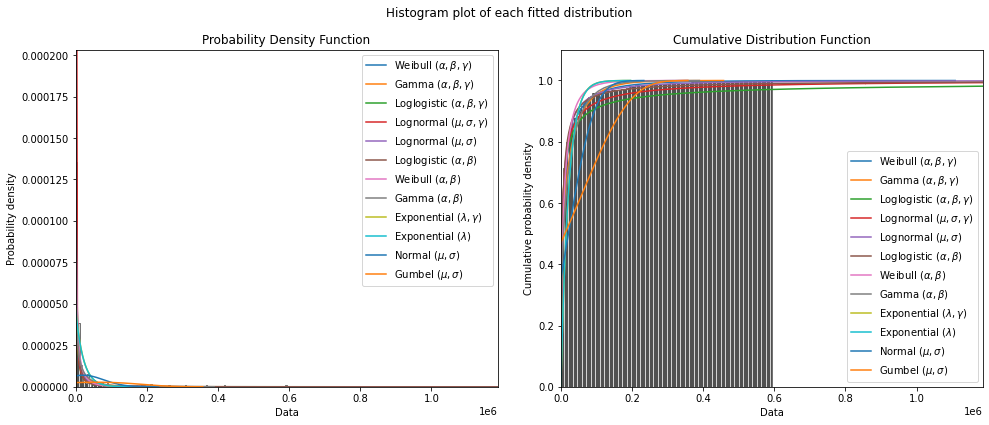

The best fitting distribution was Weibull_3P which had parameters [8.40701430e+03 4.54859607e-01 1.99999900e+02]
Subsystem: MEM


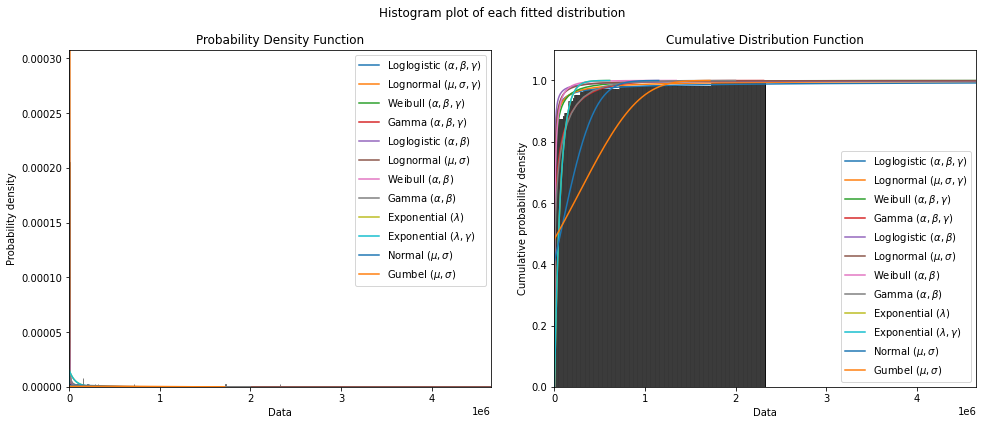

The best fitting distribution was Loglogistic_3P which had parameters [6.72523964e+02 5.46970278e-01 1.99999900e+02]
Subsystem: I-O


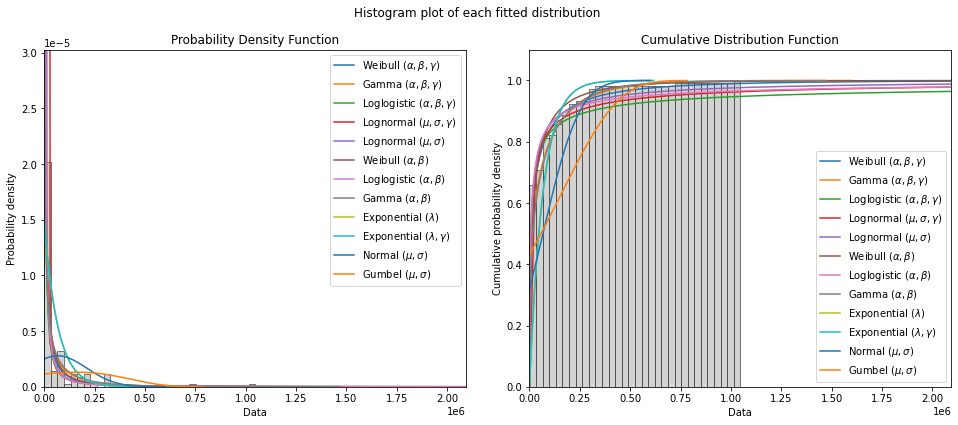

The best fitting distribution was Weibull_3P which had parameters [2.20669245e+04 3.97370861e-01 1.07999900e+02]
Subsystem: NET


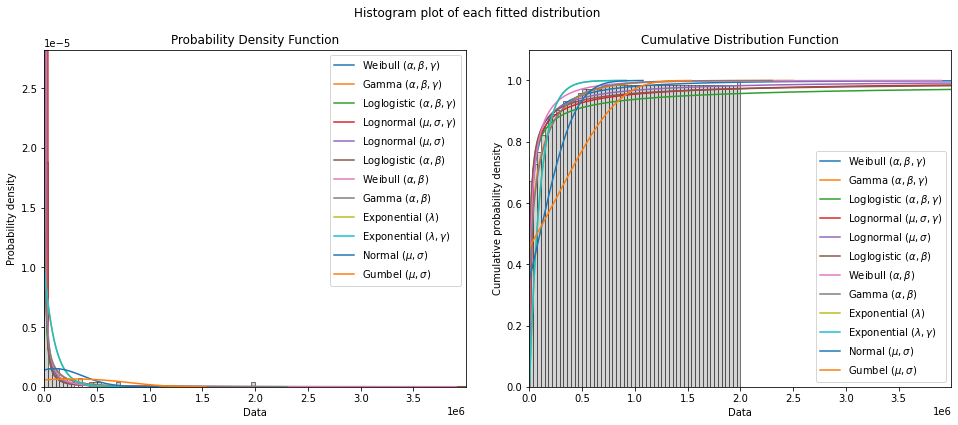

The best fitting distribution was Weibull_3P which had parameters [2.84207649e+04 3.86732768e-01 1.04999900e+02]
Subsystem: PRO


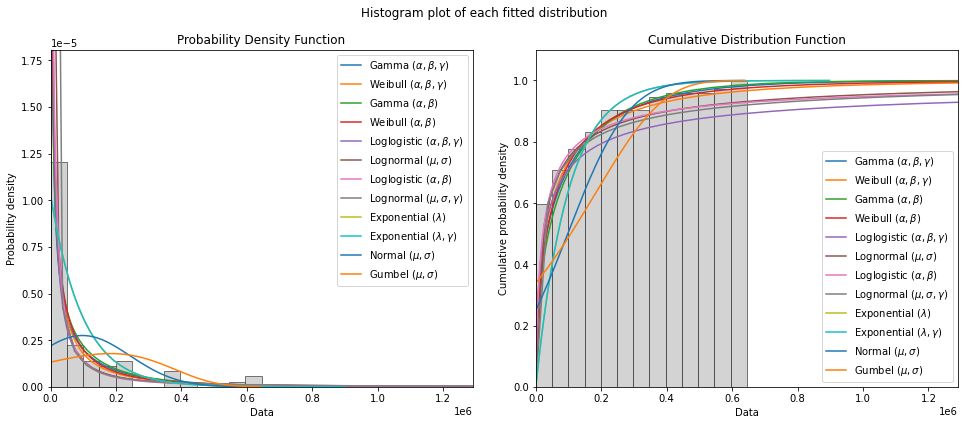

The best fitting distribution was Gamma_3P which had parameters [2.62583554e+05 3.70884964e-01 1.05999900e+02]


In [65]:
for subsys in subsystems.index:
    print('Subsystem:', subsys)
    data = dict_df_cat_stat[subsys]['Interarrival'].dropna().to_numpy()
    
    try:
        results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
        print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)
    except Exception as e:
        print('Exception:', e)

### Empirical reliability

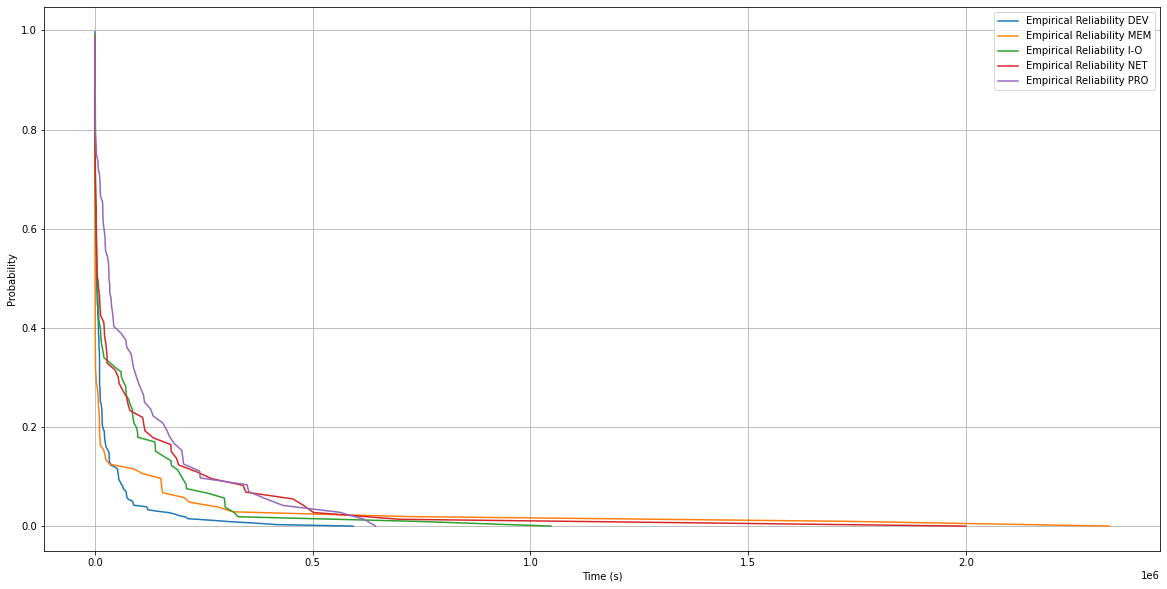

In [66]:
plt.figure(figsize=(20,10))
    
for subsys in subsystems.index:
    
    ecdf = ECDF(dict_df_cat_stat[subsys]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(subsys))
    plt.xlabel('Time (s)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid()

## Types

### Empirical time to failure distribution

Type: computation


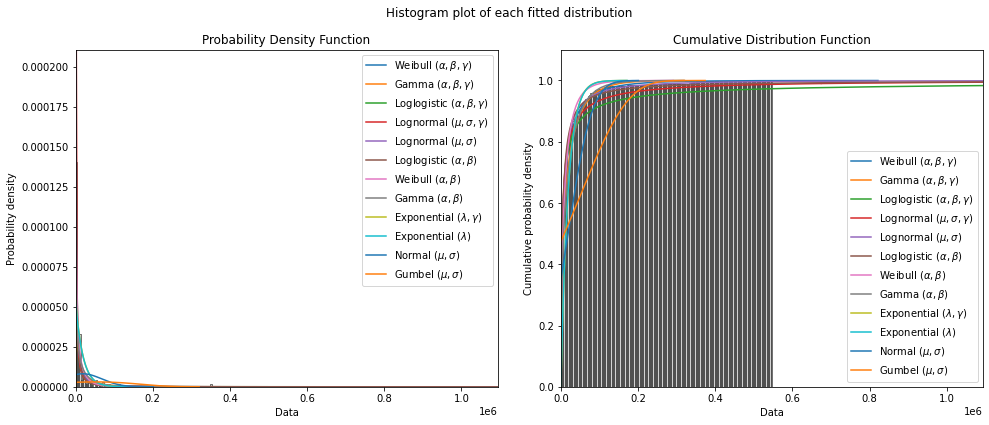

The best fitting distribution was Weibull_3P which had parameters [8.47335884e+03 4.85382713e-01 1.99999900e+02]
Type: master


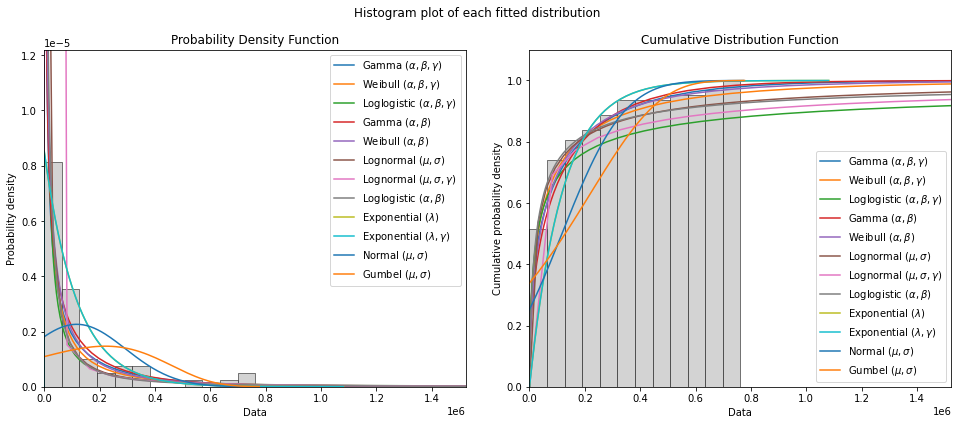

The best fitting distribution was Gamma_3P which had parameters [3.39904866e+05 3.45022346e-01 1.84999900e+02]
Type: storage


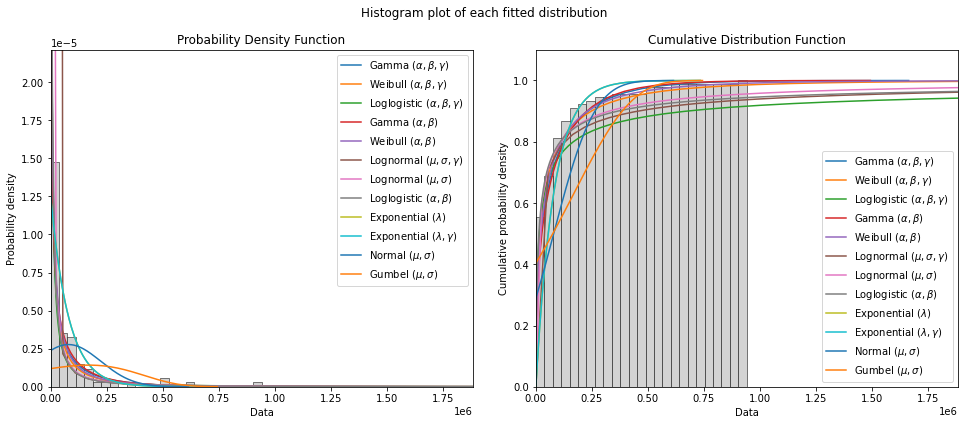

The best fitting distribution was Gamma_3P which had parameters [2.43786307e+05 3.26897268e-01 1.07999900e+02]
Type: login


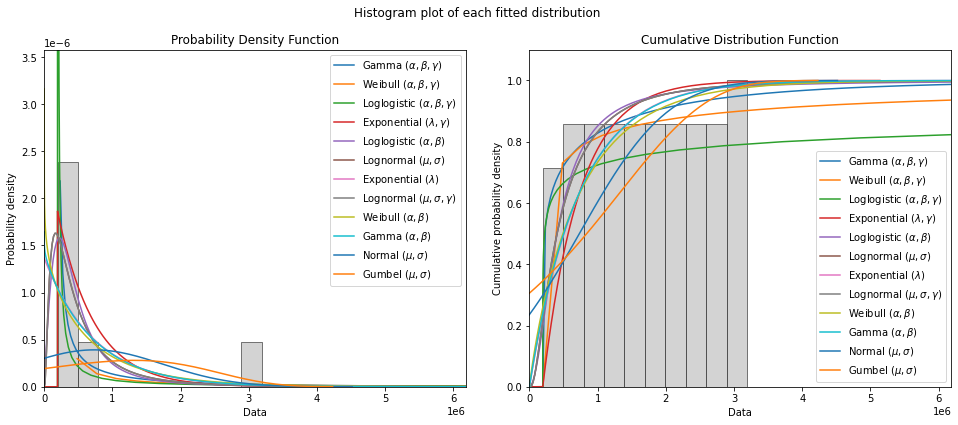

The best fitting distribution was Gamma_3P which had parameters [3.29605601e+06 1.62881377e-01 1.95077000e+05]


In [67]:
for t in types.index:
    print('Type:', t)
    data = dict_df_type_stat[t]['Interarrival'].dropna().to_numpy()
    
    try:
        results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
        print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)
    except Exception as e:
        print('Exception:', e)

### Empirical reliability

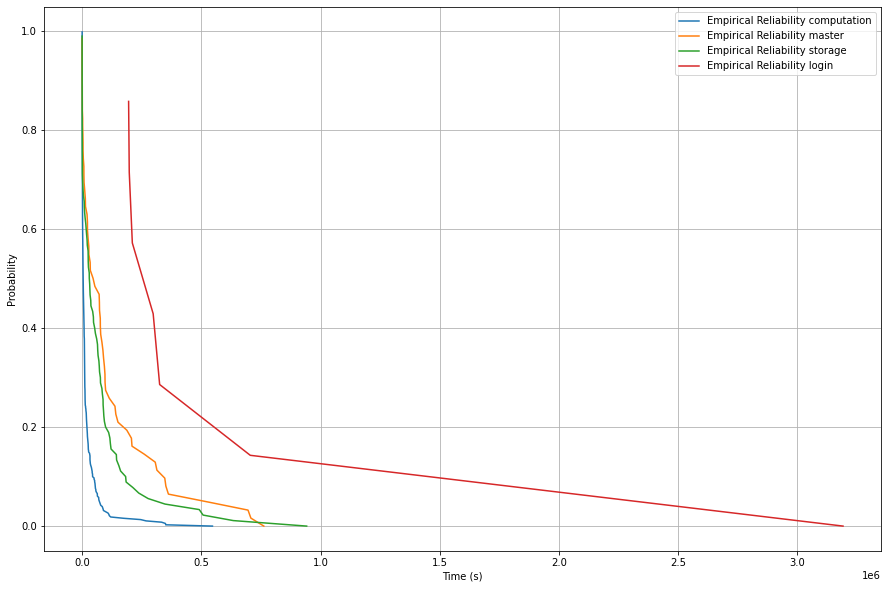

In [68]:
plt.figure(figsize=(15,10))
    
for t in types.index:
    ecdf = ECDF(dict_df_type_stat[t]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(t))

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()

## Top Nodes

### Empirical time to failure distribution

Node: tg-c401


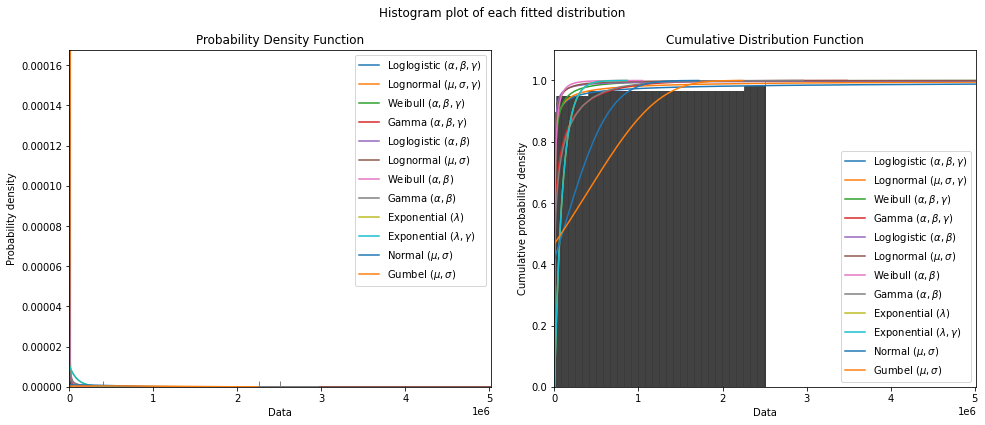

The best fitting distribution was Loglogistic_3P which had parameters [8.07878977e+02 5.06861718e-01 2.03999900e+02]
Node: tg-master


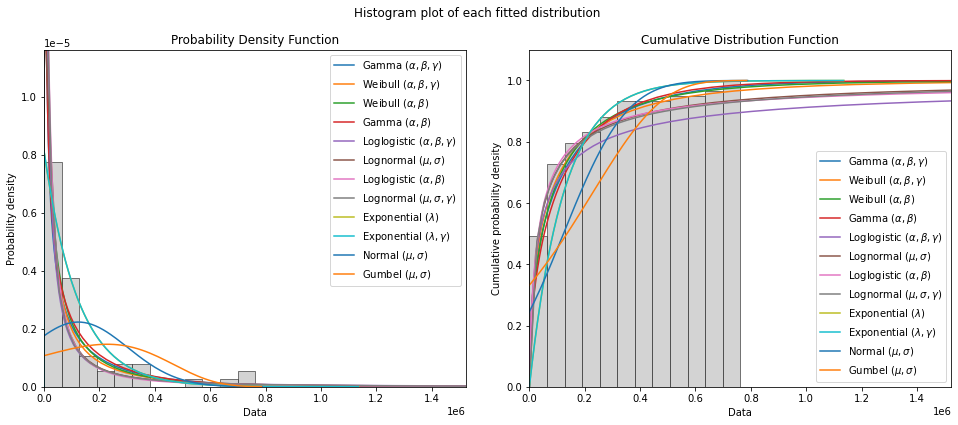

The best fitting distribution was Gamma_3P which had parameters [3.05994004e+05 4.02660321e-01 2.10999900e+02]


In [69]:
top_2 = [k for k in dict_node_num_tup if dict_node_num_tup[k] > 30]

for node in top_2:
    print('Node:', node)
    data = dict_df_node_stat[node]['Interarrival'].dropna().to_numpy()
    
    results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
    print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

### Empirical reliability

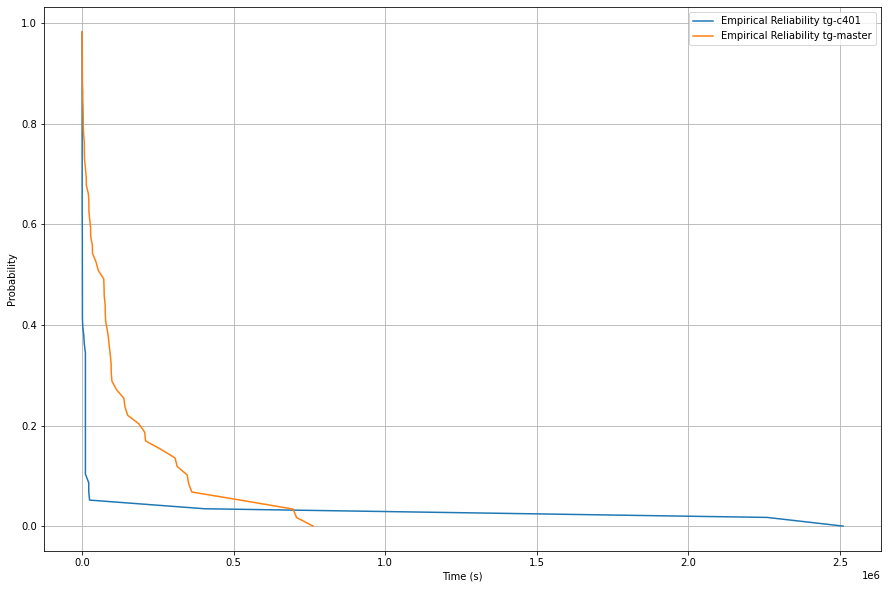

In [70]:
plt.figure(figsize=(15,10))
    
for node in top_2:
    ecdf = ECDF(dict_df_node_stat[node]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(node))

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()

## Bottleneck

### Empirical time to failure distribution

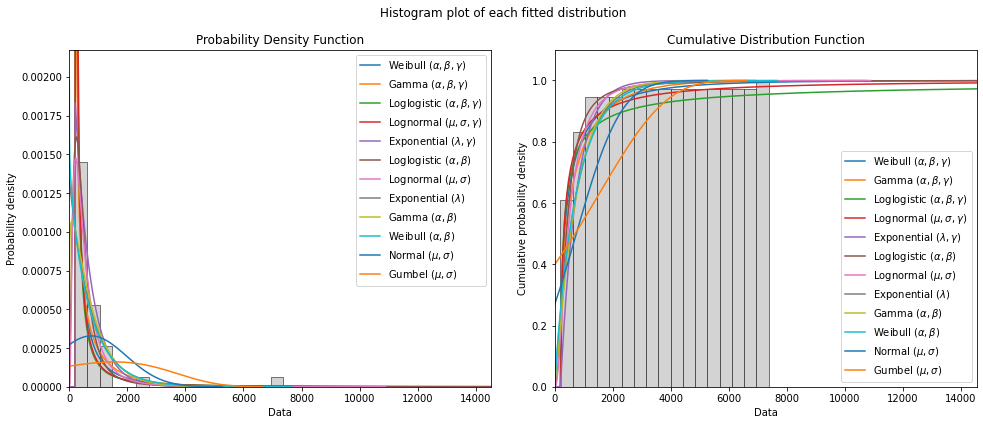

The best fitting distribution was Weibull_3P which had parameters [278.67054042   0.50538949 203.9999    ]


In [71]:
data = df_bottleneck_stat['Interarrival'].dropna().to_numpy()
   
results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

### Empirical reliability

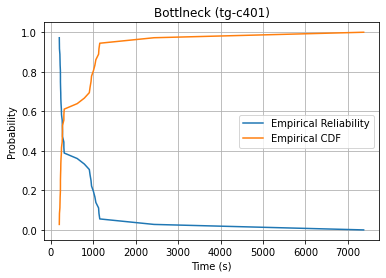

In [72]:
ecdf = ECDF(df_bottleneck_stat['Interarrival'].dropna())

plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')
plt.title('Bottlneck (tg-c401)')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()

### General Analysis

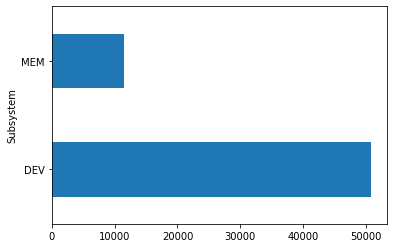

In [73]:
df_bottleneck.groupby(by='Subsystem').Timestamp.count().plot.barh()
plt.show()

In [74]:
df_bottleneck.groupby(by=['Subsystem','Message']).count().drop(columns=['Node', 'Type', 'Tuple'])

Timestamp
Subsystem Message                                              
DEV       + Platform Specific Error Detail:                5474
          +BEGIN HARDWARE ERROR STATE AT CPE               6030
          +END HARDWARE ERROR STATE AT CPE                 3830
          +Platform PCI Component Error Info Section       6805
          +Platform Specific Error Info Section            5416
          Component Info: Vendor Id =x x                  23152
MEM       + Mem Error Detail:                                 4
          Physical Address x                              11552

In [75]:
# risolvere truncation e collision
# clustering